# Climate Data Store (CDS) -  Backend


Copernicus Climate Change Service (C3S) - Upper Air Data Service

The purpose of this IPython Notebook is to demonstrate the access and usability of the proposed data delivering service. Example usage of the Climate Data Store (CDS) Backend for Radiosonde data.

For further information please refer to the Deliverable **DC3S311c_Lot2.3.1.1** on [Github CEUAS](https://github.com/MBlaschek/CEUAS/tree/master/CEUAS/public/cds-backend).


    Author: M. Blaschek
    Date: 01.2020
    Contact: michael.blaschek [at] univie.ac.at
    

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
# Plotting parameters
plt.rcParams['figure.figsize'] = [12.0, 6.0]
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.size'] = 15
plt.style.use('seaborn-colorblind')
yplevs = np.array([10,30,70,125,175,225,300,400,500,700,925])*100.

In [6]:
#
# Make sure you have Python 3
#
from platform import python_version
if python_version()[0] != '3':
    print("Your Version:", python_version())
    raise RuntimeError("This Notebook requires Python 3")

# Functionality of the delivering server

The backend expects HTTP POST requests, where the query string must be in JSON format. In the Deliverable Document Table 1 describes the allowed keys and values of the requests. HTTP GET requests may work as well but are accepted only for debugging.

The backend returns files, which are either
1. Zip files containing CF 1.7 compliant netCDF4 files  (one per station). The default name is download.zip.
2. JSON files containing error messages, if a HTTP error occurs


The interface can be a pure python code or via a linux shell.

* [Python Interface](#Python-version)
* [Shell Interface](#Shell)


A typical request should contain:
1. **statid** - the Station Identifier
    * e.g. `'11035' or ['11035','72357'] or 'all'`
2. **date** - datetime selection YYYYMMDD
    * e.g. `one day 19990101 or a range [19990101, 19991231]`
3. **pressure_level** - selection of pressure levels
    * e.g. `one level [85000] or [50000, 85000] or no keyword for all significant levels`
4. **variable** - selection of variables 
    * e.g. `'temperature', 'relative_humidity', ...`
5. **fbstats**  - feedback information from reanalysis
    * e.g. `'obs_minus_an', obs_minus_fg', ...`

## Python version

The requested data can be unzippped in memory to a data directory.

In [7]:
import requests, zipfile, io, os, time
t0 = time.time()
# http://early-upper-air.copernicus-climate.eu
r = requests.post('http://srvx8.img.univie.ac.at:8004',
                  headers={'content-type': 'application/json'},
                  json={"statid": "11035",
                        "date": [20000101, 20000101],
                        "pressure_level": [1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000,
                                           50000, 70000, 85000, 92500, 100000],
                        "variable": ["temperature", "relative_humidity"],
                        "fbstats": ["obs_minus_bg", "obs_minus_an", "bias_estimate"]
                        },
                  stream=True)
#
# Check for known Error Message
#
if r.status_code != requests.codes.ok:
     print(r.text)
     raise RuntimeError("Something is not correct with the request")
#
# Create directory
#
if not os.path.isdir('./example_data'):
    os.makedirs('./example_data')
#
# Unzip the Data Stream
#
try:
    z = zipfile.ZipFile(io.BytesIO(r.content))
    print("Unzipping retrieved files: to ./exampla_data")
    print(z.namelist())
    z.extractall(path='./example_data')
    z.close()
except:
    print(r.text)
    print("Error in request")
print("Time elapsed: ", time.time()-t0, "s")

Unzipping retrieved files: to ./exampla_data
['dest_11035_air_temperature.nc', 'dest_11035_relative_humidity.nc']
Time elapsed:  0.7365279197692871 s


## Shell

Another Way can be use a Linux tool called `curl` to download a zipfile. 
The request (`--data ...`) is identical to the above python request and also the retrieved file is identical. The retrieved file needs to be unzipped.


In [8]:
!curl -H "Content-Type: application/json" -X POST --digest --data '{"statid":"11035","date":[20000101,20000101],"pressure_level":[1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 70000, 85000, 92500, 100000],"variable":["temperature","relative_humidity"],"fbstats":["obs_minus_bg","obs_minus_an","bias_estimate"]}' -o example_data/download.zip http://srvx8.img.univie.ac.at:8004

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 77106  100 76830  100   276   324k   1194 --:--:-- --:--:-- --:--:--  325k


In [9]:
# The retrieved zipfile can be extracted:
!test -e example_data/download.zip && unzip -o example_data/download.zip -d example_data && rm example_data/download.zip

Archive:  example_data/download.zip
 extracting: example_data/dest_11035_air_temperature.nc  
 extracting: example_data/dest_11035_relative_humidity.nc  


In [10]:
# Show the new downloaded files in example_data directory
!tree -Dhr

.
├── [ 44K Jan 27 15:30]  Example.ipynb
├── [4.0K Jan 27 15:33]  example_data
│   ├── [ 29K Jan 27 11:12]  dest_11240_relative_humidity.nc
│   ├── [ 29K Jan 27 11:12]  dest_11240_air_temperature.nc
│   ├── [ 29K Jan 27 11:12]  dest_11120_relative_humidity.nc
│   ├── [ 29K Jan 27 11:12]  dest_11120_air_temperature.nc
│   ├── [ 37K Jan 27 15:33]  dest_11035_relative_humidity.nc
│   ├── [ 37K Jan 27 15:33]  dest_11035_air_temperature.nc
│   ├── [ 29K Jan 27 11:12]  dest_11010_relative_humidity.nc
│   └── [ 29K Jan 27 11:12]  dest_11010_air_temperature.nc
└── [   6 Jan 24  9:28]  code

2 directories, 9 files


# Retrieved files

In [11]:
import xarray as xr

In [12]:
# Open Netcdf with Xarray
tdata = xr.open_dataset('example_data/dest_11035_air_temperature.nc')
tdata

<xarray.Dataset>
Dimensions:           (obs: 31, trajectory: 2)
Coordinates:
    lat               (obs) float32 ...
    lon               (obs) float32 ...
    plev              (obs) float32 ...
    time              (obs) datetime64[ns] ...
Dimensions without coordinates: obs, trajectory
Data variables:
    bias_estimate     (obs) float32 ...
    obs_minus_an      (obs) float32 ...
    obs_minus_bg      (obs) float32 ...
    ta                (obs) float32 ...
    trajectory_index  (obs) int32 ...
    trajectory_label  (trajectory) |S5 ...
Attributes:
    primary_id:    0-20000-0-11035
    station_name:  WIEN/HOHE WARTE (11035-0)
    Conventions:   CF-1.7
    source:        radiosonde
    featureType:   trajectory
    history:       Created by Copernicus Early Upper Air Service Version 0, 2...

## Variables

Notice that there are the following variables:
* `bias_estimate` - Reanalysis Bias estimate
* `obs_min_an` - Analysis Departures
* `obs_min_bg` - First Guess Departures
* `ta` - Observations, e.g. Air Temperature
* `trajectory_index` - unique profile identifier, where each observation belongs to
* `trajectory_label` - unique profile label, as in the CDM tables

Notice as well the differen Coordinates and Dimensions:
* `obs` - Dimension that corresponds to a record lenght (all profiles together)
* `trajectory`  - Dimension that corresponds to a number of individual profiles
* `lat` - Coordinate Information Latitude
* `lon` - Coordinate Information Longitude
* `plev` - Coordinate Information pressure
* `time` - Coordinate Information time

# Request a profile

Tasks:
* One station: `11035`
* One datetime: `20000101`
* Two variables: `temperature, relative humidity`
* Notice no `pressure_level`, thus requesting significant level data.

In [13]:
import requests, zipfile, io, os, time
t0 = time.time()
# http://early-upper-air.copernicus-climate.eu
#
# All levels for one day
#
r = requests.post('http://srvx8.img.univie.ac.at:8004',
                  headers={'content-type': 'application/json'},
                  json={"statid": "11035",
                        "date": [20000101, 20000101],
                        "variable": ["temperature", "relative_humidity"]
                        },
                  stream=True)
#
# Check for known Error Message
#
if r.status_code != requests.codes.ok:
     print(r.text)
     raise RuntimeError("Something is not correct with the request")
#
# Create directory
#
if not os.path.isdir('./example_data'):
    os.makedirs('./example_data')
#
# Unzip the Data Stream
#
try:
    z = zipfile.ZipFile(io.BytesIO(r.content))
    print("Retreived files: ")
    print(z.namelist())
    z.extractall(path='./example_data')
    z.close()
except:
    print(r.text)
    print("Error in request")
print("Time elapsed: ", time.time()-t0, "s")

Retreived files: 
['dest_11035_air_temperature.nc', 'dest_11035_relative_humidity.nc']
Time elapsed:  0.2592439651489258 s


## Read the NetCDF to xarray

In [18]:
tdata = xr.load_dataset('example_data/dest_11035_air_temperature.nc')
rdata = xr.load_dataset('example_data/dest_11035_relative_humidity.nc')

In [19]:
# This is the xarray representation of the NetCDF file
tdata

<xarray.Dataset>
Dimensions:           (obs: 190, trajectory: 2)
Coordinates:
    lat               (obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    lon               (obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    plev              (obs) float32 590.0 660.0 760.0 ... 95700.0 97400.0
    time              (obs) datetime64[ns] 2000-01-01 ... 2000-01-01T12:00:00
Dimensions without coordinates: obs, trajectory
Data variables:
    ta                (obs) float32 211.3 nan 206.5 205.9 ... 269.7 271.9 nan
    trajectory_index  (obs) int32 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1
    trajectory_label  (trajectory) |S5 b'30635' b'30637'
Attributes:
    primary_id:    0-20000-0-11035
    station_name:  WIEN/HOHE WARTE (11035-0)
    Conventions:   CF-1.7
    source:        radiosonde
    featureType:   trajectory
    history:       Created by Copernicus Early Upper Air Service Version 0, 2...

## Plot a profile

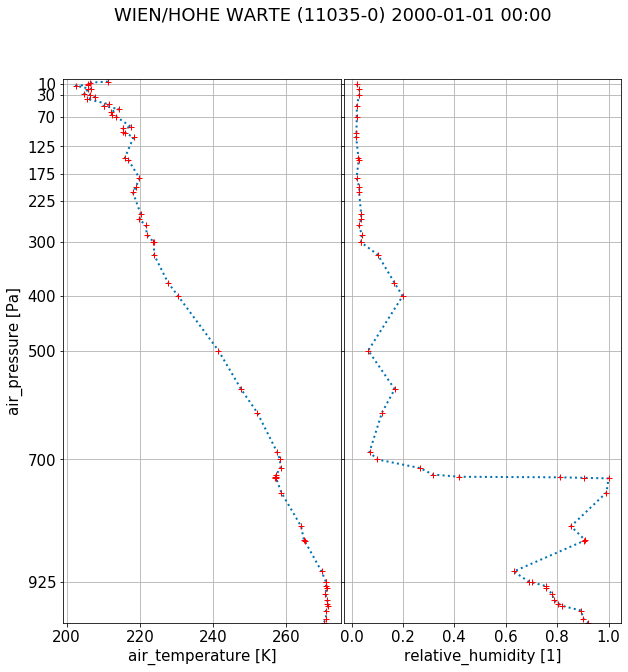

In [20]:
#
# Select 00Z, change dimension to pressure, drop missing values
#
plotdata = tdata.sel(obs=tdata.time.dt.hour==0).ta.swap_dims({'obs':'plev'}).to_dataset()
plotdata['hur'] = rdata.sel(obs=rdata.time.dt.hour==0).hur.swap_dims({'obs':'plev'})
#
# Plotting
#
f, [ax,ay] = subplots(1,2, sharey=True, figsize=(10,10))
plotdata.ta.dropna('plev').plot(y='plev', marker='+', ls=':', mec='red', ax=ax)
plotdata.hur.dropna('plev').plot(y='plev', marker='+', ls=':', mec='red', ax=ay)
# ax.set_yscale('log')
ax.set_yticks(ticks=yplevs)
ax.set_yticklabels(map("{:.0f}".format,yplevs/100))
ax.set_ylim(100000,100)
ay.set_ylim(100000,100)
ax.grid()
ay.grid()
ay.set_ylabel('')
subplots_adjust(wspace=0.01)
f.suptitle("{} {}".format(tdata.attrs['station_name'], plotdata.time.dt.strftime("%Y-%m-%d %H:%M").item(0)),);

# Request a timeseries

Tasks:
* One Station: `11035`
* Datetime range: `20000101 - 20181231`
* Two variables: `temperature, relative humidity`
* One pressure level: `85000`


In [21]:
import requests, zipfile, io, os, time
t0 = time.time()
# http://early-upper-air.copernicus-climate.eu
r = requests.post('http://srvx8.img.univie.ac.at:8004',
                  headers={'content-type': 'application/json'},
                  json={"statid": "11035",
                        "date": [20000101, 20180101],
                        "variable": ["temperature", "relative_humidity"],
                        "pressure_level": [85000, 85000]
                        },
                  stream=True)
#
# Check for known Error Message
#
if r.status_code != requests.codes.ok:
     print(r.text)
     raise RuntimeError("Something is not correct with the request")
#
# Create directory
#
if not os.path.isdir('./example_data'):
    os.makedirs('./example_data')
#
# Unzip the Data Stream
#
try:
    z = zipfile.ZipFile(io.BytesIO(r.content))
    print("Retreived files: ")
    print(z.namelist())
    z.extractall(path='./example_data')
    z.close()
except:
    print(r.text)
    print("Error in request")
print("Time elapsed: ", time.time()-t0, "s")

Retreived files: 
['dest_11035_air_temperature.nc', 'dest_11035_relative_humidity.nc']
Time elapsed:  4.293455362319946 s


## Read NetCDF to xarray

In [22]:
tdata = xr.load_dataset('example_data/dest_11035_air_temperature.nc')
rdata = xr.load_dataset('example_data/dest_11035_relative_humidity.nc')

In [23]:
# Again the representation of the NetCDF file, 
# Notice the number of trajectories (13879), this is basically the amount of profiles in the file.
tdata

<xarray.Dataset>
Dimensions:           (obs: 15933, trajectory: 13879)
Coordinates:
    lat               (obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    lon               (obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    plev              (obs) float32 85000.0 85000.0 85000.0 ... 85000.0 85000.0
    time              (obs) datetime64[ns] 2000-01-01 ... 2018-01-01T23:30:27
Dimensions without coordinates: obs, trajectory
Data variables:
    ta                (obs) float32 265.1 266.3 267.9 ... 273.66 273.48 273.48
    trajectory_index  (obs) int32 0 1 2 3 4 5 ... 13876 13877 13877 13878 13878
    trajectory_label  (trajectory) |S5 b'30635' b'30637' ... b'53290' b'53291'
Attributes:
    primary_id:    0-20000-0-11035
    station_name:  WIEN/HOHE WARTE (11035-0)
    Conventions:   CF-1.7
    source:        radiosonde
    featureType:   trajectory
    history:       Created by Copernicus Early Upper Air Service Version 0, 2...

## Plot a timeseries

/raid8/srvx1/mblaschek/.conda/envs/bunnies/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


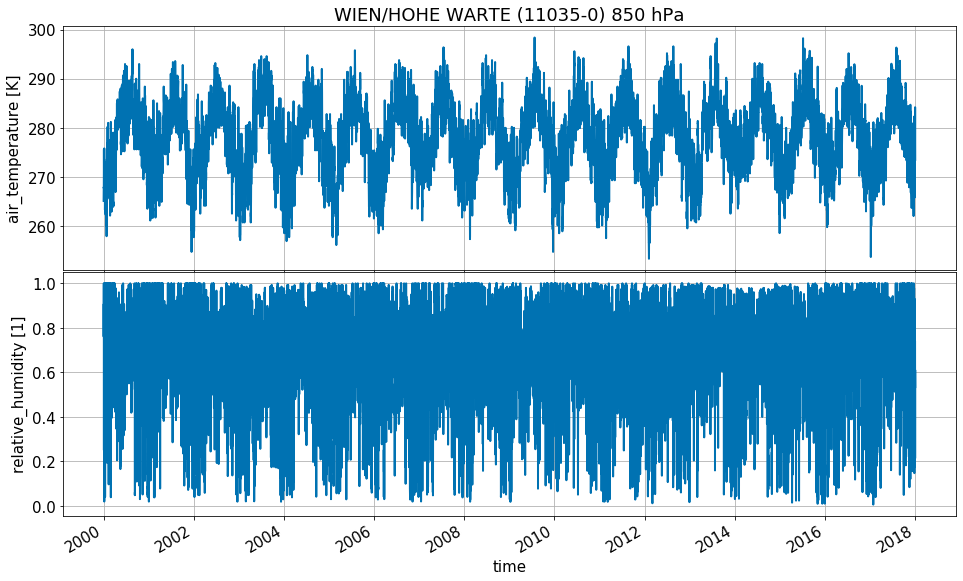

In [24]:
#
# Select 00Z, change dimension to pressure, drop missing values
#
plotdata = tdata.ta.swap_dims({'obs':'time'}).to_dataset()
plotdata['hur'] = rdata.hur.swap_dims({'obs':'time'})
#
# Plotting
#
f, [ax,ay] = subplots(2,1, sharex=True, figsize=(16,9))
plotdata.ta.dropna('time').plot(x='time', ax=ax)
plotdata.hur.dropna('time').plot(x='time', ax=ay)
ax.grid()
ax.set_xlabel('')
ay.grid()
subplots_adjust(hspace=0.01)
ax.set_title("{} {:.0f} hPa".format(tdata.attrs['station_name'], plotdata.plev.values[0]/100));

# Request multiple Stations

Tasks:
* 4 Stations: `11035,11010,11120,11240`
    - Vienna, Linz, Innsbruck and Graz. Four Stations from Austria
* One day: `20000101 - 20000101`
* Two variables: `temperature, relative humidity`
* One pressure level: `85000`

In [25]:
import requests, zipfile, io, os, time
t0 = time.time()
# http://early-upper-air.copernicus-climate.eu
r = requests.post('http://srvx8.img.univie.ac.at:8004',
                  headers={'content-type': 'application/json'},
                  json={"statid": ["11035", "11010", "11120", "11240"],
                        "date": [20000101, 20000101],
                        "variable": ["temperature", "relative_humidity"],
                        "pressure_level": [85000, 85000]
                        },
                  stream=True)
#
# Check for known Error Message
#
if r.status_code != requests.codes.ok:
     print(r.text)
     raise RuntimeError("Something is not correct with the request")
#
# Create directory
#
if not os.path.isdir('./example_data'):
    os.makedirs('./example_data')
#
# Unzip the Data Stream
#
try:
    z = zipfile.ZipFile(io.BytesIO(r.content))
    print("Retreived files: ")
    print(z.namelist())
    z.extractall(path='./example_data')
    z.close()
except:
    print(r.text)
    print("Error in request")
print("Time elapsed: ", time.time()-t0, "s")

Retreived files: 
['dest_11035_air_temperature.nc', 'dest_11035_relative_humidity.nc', 'dest_11010_air_temperature.nc', 'dest_11010_relative_humidity.nc', 'dest_11120_air_temperature.nc', 'dest_11120_relative_humidity.nc', 'dest_11240_air_temperature.nc', 'dest_11240_relative_humidity.nc']
Time elapsed:  1.810685634613037 s


## Read NetCDF to xarray

In [26]:
data = {}
for ifile in os.listdir('./example_data/'):
    ident = ifile.split('_')[1]
    
    if ident not in data.keys():
        data[ident] = []
    #
    # Load the NetCDF data
    #
    tmp = xr.load_dataset('./example_data/' + ifile)
    #
    # Add Sonde ID as coordinate
    #
    tmp.coords['sonde'] = ident
    #
    # Drop
    #
    tmp = tmp.drop(['trajectory_index', 'trajectory_label'])
    #
    # Use time as dimension
    #
    tmp = tmp.swap_dims({'obs':'time'})
    data[ident].append(tmp)
#
# Merge Variables per Sonde into one Dataset
#
for ikey in data.keys():
    data[ikey] = xr.merge(data[ikey])
#
# Make a larger dataset
#
data = xr.concat(data.values(), dim='sonde')

In [27]:
data

<xarray.Dataset>
Dimensions:  (sonde: 4, time: 4)
Coordinates:
    lat      (time) float32 nan nan nan nan
    lon      (time) float32 nan nan nan nan
  * time     (time) datetime64[ns] 2000-01-01 ... 2000-01-01T12:00:00
    plev     (sonde, time) float32 nan nan 85000.0 nan ... nan nan 85000.0
  * sonde    (sonde) object '11010' '11120' '11240' '11035'
Data variables:
    ta       (sonde, time) float32 nan nan 266.9 nan ... 265.1 nan nan 266.3
    hur      (sonde, time) float32 nan nan 0.837089 nan ... nan nan 0.760778

## Merged Dataset

Notice that we have 4 Sondes and 4 times. This happens because the reported times are launch times. 

We can have a look at the temperature information. 
1. Vienna (11035) has soundings at 00Z and 12Z
2. Linz (11010) has one sounding at 05Z
3. Innsbruck (11120) has one sounding at 00Z
4. Graz (11240) has one sounding at 04Z

In [28]:
print(data.ta)

<xarray.DataArray 'ta' (sonde: 4, time: 4)>
array([[  nan,   nan, 266.9,   nan],
       [266.5,   nan,   nan,   nan],
       [  nan, 265.7,   nan,   nan],
       [265.1,   nan,   nan, 266.3]], dtype=float32)
Coordinates:
    lat      (time) float32 nan nan nan nan
    lon      (time) float32 nan nan nan nan
  * time     (time) datetime64[ns] 2000-01-01 ... 2000-01-01T12:00:00
    plev     (sonde, time) float32 nan nan 85000.0 nan ... nan nan 85000.0
  * sonde    (sonde) object '11010' '11120' '11240' '11035'
Attributes:
    cdmname:        observations_table/observation_value
    units:          K
    standard_name:  air_temperature
    cdsname:        temperature


In [29]:
# Vienna
print(data.sel(sonde='11035').dropna('time'))

<xarray.Dataset>
Dimensions:  (time: 2)
Coordinates:
    lat      (time) float32 nan nan
    lon      (time) float32 nan nan
  * time     (time) datetime64[ns] 2000-01-01 2000-01-01T12:00:00
    plev     (time) float32 85000.0 85000.0
    sonde    <U5 '11035'
Data variables:
    ta       (time) float32 265.1 266.3
    hur      (time) float32 0.903358 0.760778


In [30]:
# Lins
print(data.sel(sonde='11010').dropna('time'))

<xarray.Dataset>
Dimensions:  (time: 1)
Coordinates:
    lat      (time) float32 nan
    lon      (time) float32 nan
  * time     (time) datetime64[ns] 2000-01-01T05:00:00
    plev     (time) float32 85000.0
    sonde    <U5 '11010'
Data variables:
    ta       (time) float32 266.9
    hur      (time) float32 0.837089


## Preparing plotdata

In order to have a common datetime we choose here to interpolate to 06Z as a common time.
To do this be need to fill the missing information and linearly interpolate to the time:
1. `interpolate_na`, interpolate missing values, only possible for Vienna, because 04Z and 05Z lie between 00Z and 12Z.
2. `ffill`, forward fill, copies the information to other times.
3. `interp`, linearly interpolates to the wanted time 06Z.
    - Note only for Vienna the value is interpolated between 05Z and 12Z

In [31]:
plotdata = data.interpolate_na('time')
plotdata

/raid8/srvx1/mblaschek/.conda/envs/bunnies/lib/python3.7/site-packages/xarray/core/missing.py:251: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  ).transpose(*self.dims)
/raid8/srvx1/mblaschek/.conda/envs/bunnies/lib/python3.7/site-packages/xarray/core/missing.py:251: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  ).transpose(*self.dims)


<xarray.Dataset>
Dimensions:  (sonde: 4, time: 4)
Coordinates:
    lon      (time) float32 nan nan nan nan
  * time     (time) datetime64[ns] 2000-01-01 ... 2000-01-01T12:00:00
    lat      (time) float32 nan nan nan nan
  * sonde    (sonde) object '11010' '11120' '11240' '11035'
    plev     (sonde, time) float32 nan nan 85000.0 nan ... nan nan 85000.0
Data variables:
    ta       (sonde, time) float32 nan nan 266.9 nan ... 265.1 265.5 265.6 266.3
    hur      (sonde, time) float32 nan nan 0.837089 ... 0.8439497 0.760778

In [32]:
plotdata = plotdata.ffill('time')
plotdata

/raid8/srvx1/mblaschek/.conda/envs/bunnies/lib/python3.7/site-packages/xarray/core/missing.py:307: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  ).transpose(*arr.dims)


<xarray.Dataset>
Dimensions:  (sonde: 4, time: 4)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 ... 2000-01-01T12:00:00
    lat      (time) float32 nan nan nan nan
    lon      (time) float32 nan nan nan nan
  * sonde    (sonde) object '11010' '11120' '11240' '11035'
    plev     (sonde, time) float32 nan nan 85000.0 nan ... nan nan 85000.0
Data variables:
    ta       (sonde, time) float32 nan nan 266.9 266.9 ... 265.5 265.6 266.3
    hur      (sonde, time) float32 nan nan 0.837089 ... 0.8439497 0.760778

In [33]:
plotdata = plotdata.interp(time='2000-01-01 06:00:00')
plotdata

<xarray.Dataset>
Dimensions:  (sonde: 4)
Coordinates:
    lat      float64 nan
    lon      float64 nan
  * sonde    (sonde) object '11010' '11120' '11240' '11035'
    plev     (sonde) float64 nan nan nan nan
    time     datetime64[ns] 2000-01-01T06:00:00
Data variables:
    ta       (sonde) float64 266.9 266.5 265.7 265.7
    hur      (sonde) float64 0.8371 0.8366 0.7719 0.8321

In [34]:
cinfos = {'11035': {'lon': 16.3564 , 'lat':48.2486}, 
          '11010':{'lon':14.1881, 'lat':48.2353}, 
          '11120':{'lon':11.3439, 'lat':47.2603}, 
          '11240': {'lon': 15.4392, 'lat': 46.9931}}

In [35]:
plotdata['lon'] = ('sonde', [cinfos[i]['lon'] for i in plotdata.sonde.values])
plotdata['lat'] = ('sonde', [cinfos[i]['lat'] for i in plotdata.sonde.values])

In [36]:
plotdata

<xarray.Dataset>
Dimensions:  (sonde: 4)
Coordinates:
    lat      (sonde) float64 48.24 47.26 46.99 48.25
    lon      (sonde) float64 14.19 11.34 15.44 16.36
  * sonde    (sonde) object '11010' '11120' '11240' '11035'
    plev     (sonde) float64 nan nan nan nan
    time     datetime64[ns] 2000-01-01T06:00:00
Data variables:
    ta       (sonde) float64 266.9 266.5 265.7 265.7
    hur      (sonde) float64 0.8371 0.8366 0.7719 0.8321

## Plot a map

In [37]:
import cartopy.crs as ccrs
import cartopy as cpy

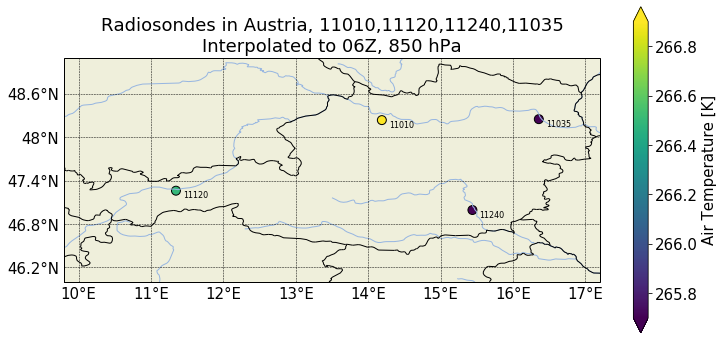

In [38]:
#
# Define the Plot
#
ax = plt.subplot(projection=ccrs.PlateCarree());
#
# Add Metainformation
#
ax.add_feature(cpy.feature.LAND, zorder=0)
ax.add_feature(cpy.feature.LAKES.with_scale('10m'), zorder=0)
ax.add_feature(cpy.feature.RIVERS.with_scale('10m'), zorder=1)
ax.add_feature(cpy.feature.BORDERS.with_scale('10m'), zorder=1)
#
# Plot the Values
#
cs = ax.scatter(plotdata.lon.values, plotdata.lat.values, 
                s=80,
                c=plotdata.ta.values,
                edgecolor='k',
                transform=ccrs.PlateCarree());
#
# Colorbar
#
cb = plt.colorbar(cs, ax=ax, extend='both')
cb.set_label("Air Temperature [K]")
ax.set_extent([9.8,17.2,46,49.1])   # set the extent of the map
#
# Add Labels
#
lloffset = [0.1]*4
for i, j, l, k in zip(plotdata.lon.values, plotdata.lat.values, plotdata.sonde.values, lloffset):
    ax.text(i + k, j, "{}".format(l), horizontalalignment='left', verticalalignment='top',
            transform=cpy.crs.PlateCarree(), fontsize=8, zorder=12,
            clip_on=True)

ax.set_title("Radiosondes in Austria, " + ",".join(plotdata.sonde.values) + "\nInterpolated to 06Z, 850 hPa");
#
# Gird lines
#
gl = ax.gridlines(draw_labels=True, xlocs=None, ylocs=None,
                  linewidth=0.5, linestyle='--', color='k')
gl.xformatter = cpy.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cpy.mpl.gridliner.LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False